# Final Code

In [178]:
# The libraries that need to be imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import json
import warnings
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

## EDA

### Company

In [63]:
companies_df = pd.read_csv("data/anonymized_hubspot_companies.csv", low_memory=False)

In [6]:
companies_df.head()

Parent Company  CCaaS  Annual Revenue Target Account Associated Contact  \
0            NaN    NaN    1.000000e+09            NaN   Contact_ef780380   
1            NaN    NaN             NaN            NaN   Contact_93373ba5   
2            NaN    NaN    5.000000e+07            NaN   Contact_2e8e0993   
3            NaN  Five9    5.000000e+07            NaN   Contact_635e44ed   
4            NaN  Five9    1.000000e+08            NaN   Contact_8d055096   

   Number of Form Submissions  Total Agents  \
0                         0.0           NaN   
1                         NaN           NaN   
2                         0.0           NaN   
3                         0.0           NaN   
4                         0.0           NaN   

                                    Web Technologies Close Date  \
0                                           Route 53        NaN   
1                                                NaN        NaN   
2  Youtube; App Nexus; Google Tag Manager; Facebo...        NaN   
3  Postmark; Facebook Advertiser; Salesforce; Goo...        NaN   
4  Microsoft Office 365; Google Tag Manager; Reca...        NaN   

   # of Agents Total  ...  BPO Program Primary Sub-Industry  \
0                NaN  ...          NaN                  NaN   
1                NaN  ...          NaN                  NaN   
2                NaN  ...          NaN                  NaN   
3                NaN  ...          NaN                  NaN   
4                NaN  ...          NaN                  NaN   

  Number of Sessions  WFM  Country/Region                  Industry  \
0                0.0  NaN   United States  HVAC and plumbing supply   
1                NaN  NaN             NaN              Pest Control   
2                0.0  NaN   United States              Pest Control   
3                0.0  NaN   United States              Pest Control   
4                0.0  NaN   United States              Pest Control   

        Create Date      Company name  Last Modified Date  BPO Program Tier  
0  2024-10-30 10:51  Company_4fc73a2a    2025-02-14 13:39               NaN  
1  2024-09-12 18:30  Company_f3f7e884    2025-02-14 13:39               NaN  
2  2024-09-03 10:44  Company_89929bed    2025-02-14 13:39               NaN  
3  2024-08-02 11:36  Company_33dbf591    2025-02-14 13:39               NaN  
4  2024-08-02 11:36  Company_a3079821    2025-02-14 13:39               NaN  

[5 rows x 46 columns]

In [8]:
# Create a new column 'Close YN' to indicate whether the deal is closed ('Y') or not ('N') based on the presence of 'Close Date'
companies_df['Close YN'] = np.where(companies_df['Close Date'].isna(), 'N', 'Y')

In [11]:
# Remove outliers from a column using the IQR (Interquartile Range) method
def remove_outliers(col_data):
    # Calculate Q1, Q3, and IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return col_data[(col_data >= lower_bound) & (col_data <= upper_bound)]

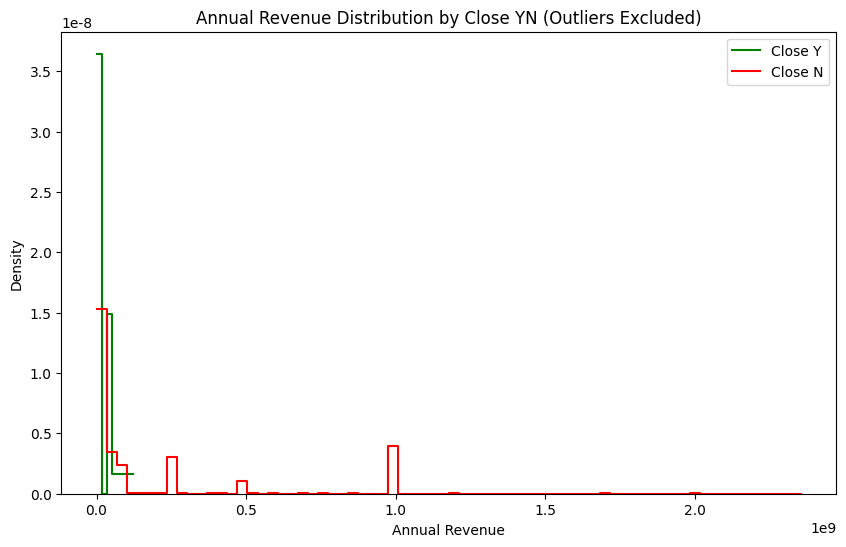

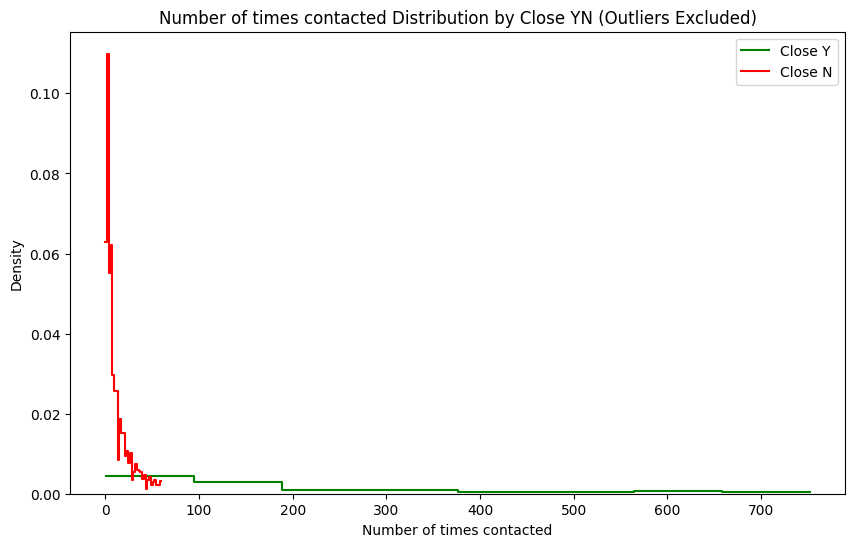

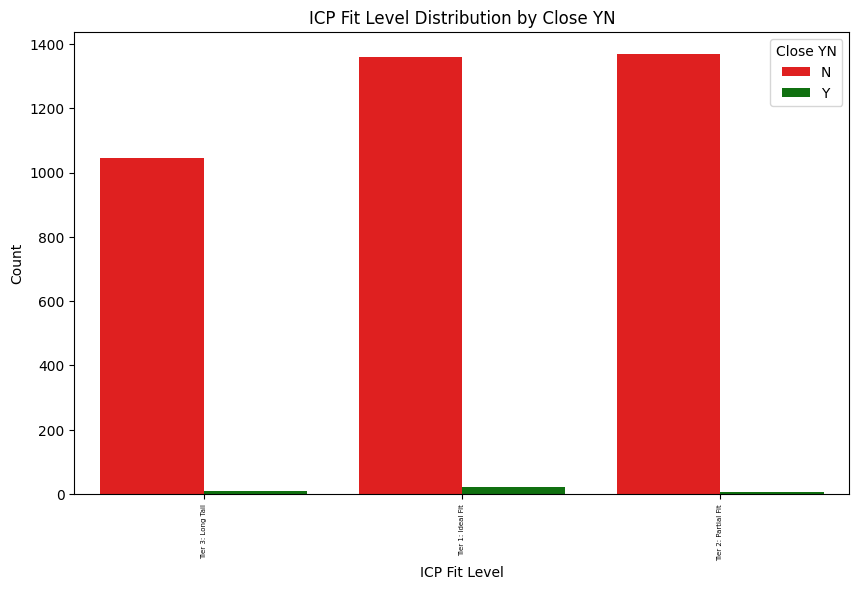

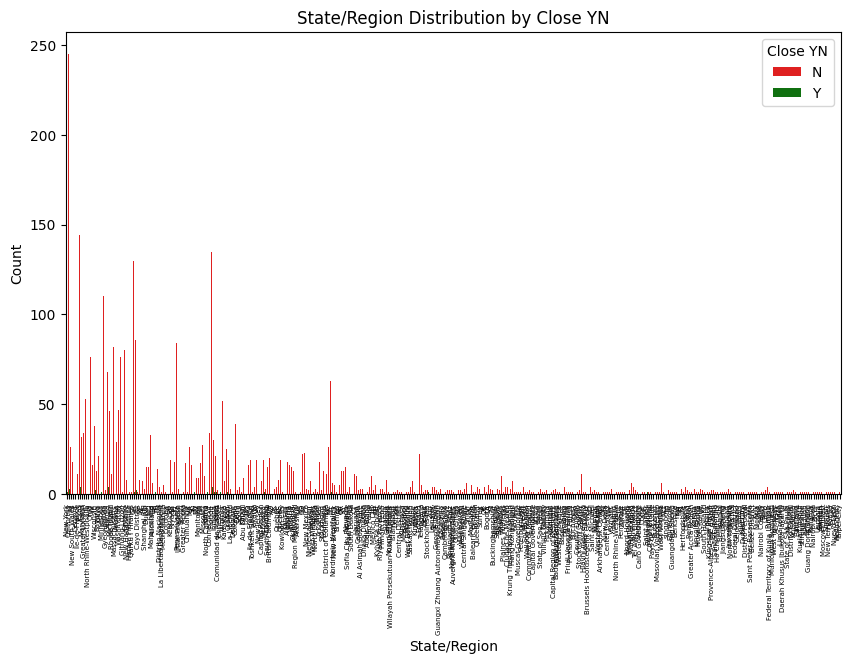

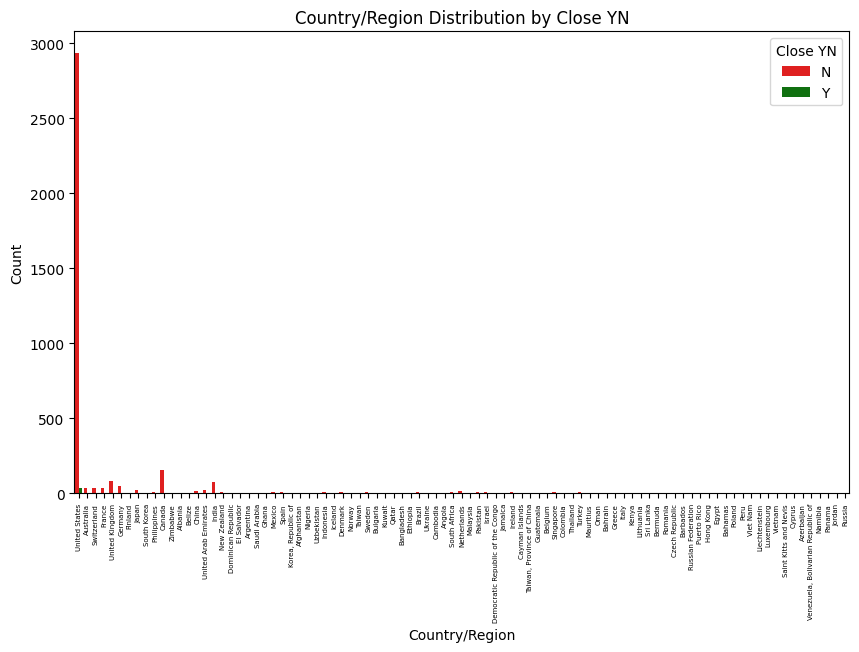

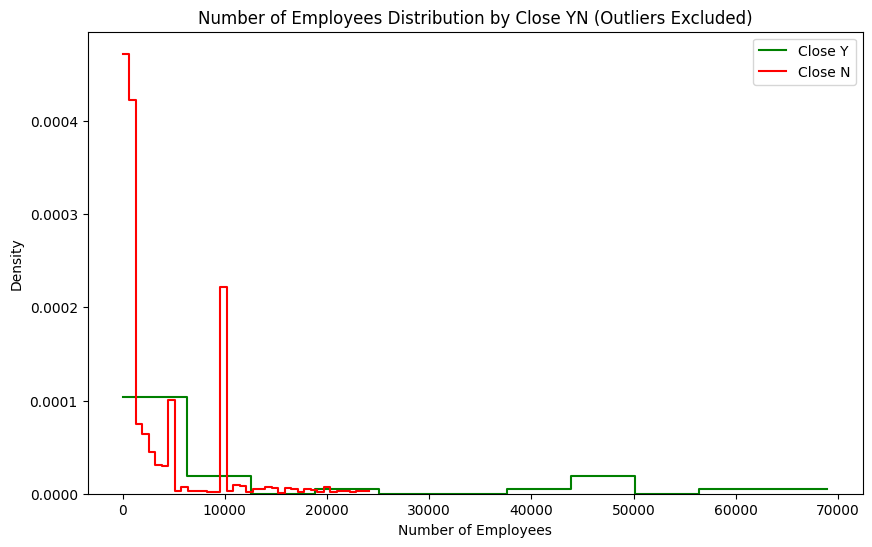

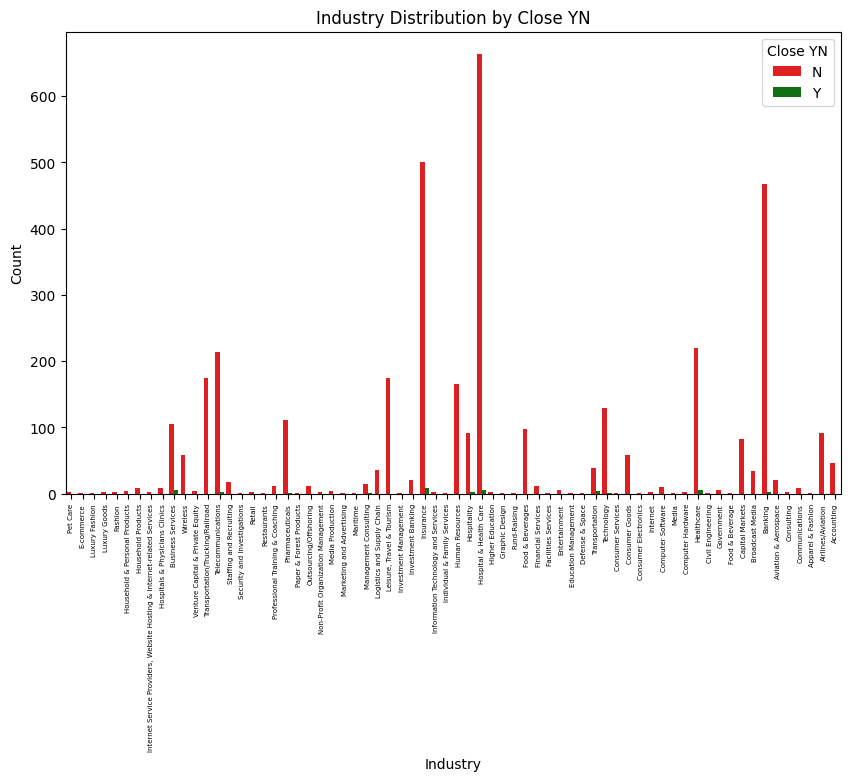

In [16]:
columns_to_analyze = [
    'Annual Revenue', 'Number of times contacted', 'ICP Fit Level', 
    'State/Region', 'Country/Region', 'Number of Employees', 'Industry'
]

# Clean the DataFrame by removing rows with NA in the specified columns
df_clean = companies_df[columns_to_analyze + ['Close YN']].dropna(subset=columns_to_analyze)

warnings.filterwarnings("ignore", message="Glyph.*missing from font.*")
# Iterate over each column to perform EDA and exclude outliers before graphing
for col in columns_to_analyze:
    if df_clean[col].dtype in ['int64', 'float64']:  # Continuous variable
        # Remove outliers for the current column using the 1.5 IQR rule
        clean_data_y = remove_outliers(df_clean[df_clean['Close YN'] == 'Y'][col])
        clean_data_n = remove_outliers(df_clean[df_clean['Close YN'] == 'N'][col])

        plt.figure(figsize=(10, 6))
        
        # Plot the histogram for Close YN Y vs N, after removing outliers
        sns.histplot(clean_data_y, kde=False, color='green', label='Close Y', stat="density", element="step", fill=False)
        sns.histplot(clean_data_n, kde=False, color='red', label='Close N', stat="density", element="step", fill=False)
        
        plt.title(f'{col} Distribution by Close YN (Outliers Excluded)')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    else:  # Discrete variable
        plt.figure(figsize=(10, 6))
        
        # Count plot for Close YN Y vs N
        sns.countplot(x=col, hue='Close YN', data=df_clean, palette={'Y': 'green', 'N': 'red'})
        
        plt.title(f'{col} Distribution by Close YN')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Close YN')
        
        # Adjust x-axis labels: make them smaller and rotate vertically
        plt.xticks(rotation=90, fontsize=5)  # Rotate labels vertically and set font size to 8
        
        plt.show()

Highest number of Ys by industry:
- Business services
- Insurance
- Transportation
- Healthcare
- Banking

### Deal

In [17]:
deals_df = pd.read_csv("data/anonymized_hubspot_deals.csv")

In [19]:
print("Shape:", deals_df.shape)
print("Columns:", deals_df.columns.tolist())

Shape: (593, 50)
Columns: ['Weighted amount', 'Deal Description', 'Cumulative time in "BANT Deal. Pain ID\'ed (Sales Pipeline)" (HH:mm:ss)', 'Cumulative time in "Opportunity (Sales Pipeline)" (HH:mm:ss)', 'Days to close', 'Deal Score', 'Close Date', 'Deal source attribution 2', 'Cumulative time in "In Trial - Trial in Progress (Sales Pipeline)" (HH:mm:ss)', 'Contract Start Date', 'Cumulative time in "Partner Referrals  (Sales Pipeline)" (HH:mm:ss)', 'Cumulative time in "Closed Lost (Sales Pipeline)" (HH:mm:ss)', 'Cumulative time in "Deep Dive. PSP Drafted (Sales Pipeline)" (HH:mm:ss)', 'Pipeline', 'Record ID', 'Forecast category', 'Original Traffic Source', 'Associated Company', 'Deal owner', 'Annual contract value', 'Is Closed (numeric)', 'Amount in company currency', 'Annual recurring revenue', 'Monthly recurring revenue', 'Deal probability', 'Associated Company (Primary)', 'Is Closed Won', 'Forecast probability', 'Contract End Date', 'Last Activity Date', 'Contract Term (Months)', '

In [21]:
#Missing Value Analysis

missing = deals_df.isnull().sum()
missing_percent = (missing / len(deals_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

# Show only columns with missing values
missing_df = missing_df[missing_df['Missing Count'] > 0]
print("Columns with Missing Values:\n", missing_df)

Columns with Missing Values:
                                                     Missing Count   Missing %
Forecast probability                                          593  100.000000
Annual contract value                                         592   99.831366
Annual recurring revenue                                      592   99.831366
Monthly recurring revenue                                     592   99.831366
Total contract value                                          592   99.831366
Cumulative time in "Closed Lost (Sales Pipeline...            590   99.494098
Cumulative time in "Closed Won (Sales Pipeline)...            580   97.807757
Cumulative time in "Closed Trial (Sales Pipelin...            577   97.301855
Cumulative time in "Opportunity (Sales Pipeline...            556   93.760540
Trial Start date                                              555   93.591906
Cumulative time in "Renewals  (Sales Pipeline)"...            554   93.423272
Trial End Date                    

In [24]:
# Show by bucket
print("\n Missing Value Buckets:")
print("- No Missing:", deals_df.columns[deals_df.isnull().sum() == 0].tolist())
print("- Some Missing (<75%):", missing_df[missing_df['Missing %'] < 75].index.tolist())
print("- High Missing (≥75%):", missing_df[missing_df['Missing %'] >= 75].index.tolist())


 Missing Value Buckets:
- No Missing: ['Days to close', 'Pipeline', 'Record ID', 'Forecast category', 'Is Closed (numeric)', 'Deal probability', 'Is Closed Won', 'Is closed lost', 'Is Deal Closed?', 'Deal Name', 'Is Open (numeric)', 'Create Date', 'Last Modified Date', 'Deal Stage', 'Deal Type']
- Some Missing (<75%): ['Deal Score', 'Cumulative time in "BANT Deal. Pain ID\'ed (Sales Pipeline)" (HH:mm:ss)', 'Last Activity Date', 'Deal Description', 'Close Date', 'Deal owner', 'Associated Company (Primary)', 'Associated Company', 'Forecast amount', 'Amount in company currency', 'Weighted amount in company currency', 'Amount', 'Weighted amount', 'Original Traffic Source', 'Deal source attribution 2']
- High Missing (≥75%): ['Forecast probability', 'Annual contract value', 'Annual recurring revenue', 'Monthly recurring revenue', 'Total contract value', 'Cumulative time in "Closed Lost (Sales Pipeline)" (HH:mm:ss)', 'Cumulative time in "Closed Won (Sales Pipeline)" (HH:mm:ss)', 'Cumulative

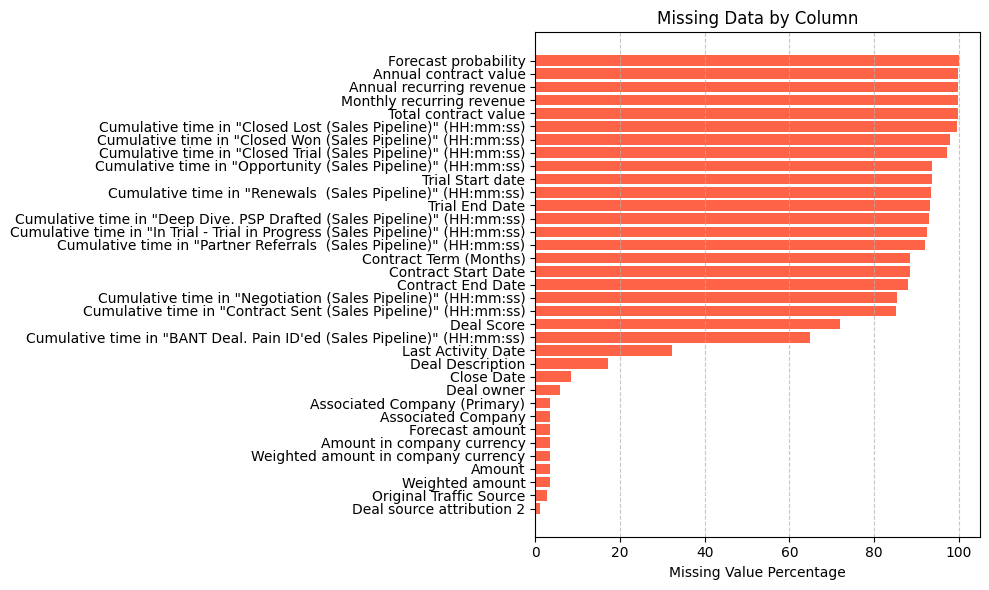

In [25]:
# Bar chart of missing data
plt.figure(figsize=(10, 6))
plt.barh(missing_df.index, missing_df['Missing %'], color='tomato')
plt.xlabel("Missing Value Percentage")
plt.title("Missing Data by Column")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
# Convert dates to datetime format
deals_df['create_date'] = pd.to_datetime(deals_df['Create Date'], errors='coerce')
deals_df['close_date'] = pd.to_datetime(deals_df['Close Date'], errors='coerce')
deals_df['last_activity'] = pd.to_datetime(deals_df['Last Activity Date'], errors='coerce')
deals_df['last_modified'] = pd.to_datetime(deals_df['Last Modified Date'], errors='coerce')

# Days to close (fallback if not provided)
if 'Days to close' not in deals_df.columns and 'create_date' in deals_df and 'close_date' in deals_df:
    deals_df['Days to close'] = (deals_df['close_date'] - deals_df['create_date']).dt.days

# Deal size category
if 'Amount' in deals_df.columns:
    deals_df['Deal_Size_Category'] = pd.cut(deals_df['Amount'], 
                                      bins=[-np.inf, 1000, 10000, 50000, np.inf], 
                                      labels=['Small', 'Medium', 'Large', 'Enterprise'])

# Extract year, month, quarter
deals_df['Create_Year'] = deals_df['create_date'].dt.year
deals_df['Create_Month'] = deals_df['create_date'].dt.month
deals_df['Create_Quarter'] = deals_df['create_date'].dt.quarter
deals_df['Close_Year'] = deals_df['close_date'].dt.year
deals_df['Close_Month'] = deals_df['close_date'].dt.month
deals_df['YearMonth'] = deals_df['create_date'].dt.to_period('M')

In [29]:
# Calculate overall win rate
win_rate = deals_df['Is Closed Won'].sum() / (deals_df['Is Closed Won'].sum() + deals_df['Is closed lost'].sum()) * 100
# Win rate by Deal Type
win_rate_by_type = deals_df.groupby('Deal Type')[['Is Closed Won', 'Is closed lost']].sum()
win_rate_by_type = (win_rate_by_type['Is Closed Won'] / 
                   (win_rate_by_type['Is Closed Won'] + win_rate_by_type['Is closed lost']) * 100)

print(win_rate)
print(win_rate_by_type)

37.264150943396224
Deal Type
Growth      47.916667
New         27.516779
PS         100.000000
Renewal     62.121212
dtype: float64


In [30]:
# Average days in pipeline by stage
avg_days_by_stage = deals_df.groupby('Deal Stage')['Days to close'].mean()
# Quarterly trend in sales cycle length
quarterly_trend = deals_df.groupby('Create_Quarter')['Days to close'].mean()

print(avg_days_by_stage)
print(quarterly_trend)

Deal Stage
BANT Deal. Pain ID'ed           260.100000
Closed Lost                     163.007519
Closed Trial                    148.000000
Closed Won                      142.987342
Contract Sent                   188.100000
Deep Dive. PSP Drafted          292.846154
In Trial - Trial in Progress    231.800000
Negotiation                     230.000000
Opportunity                     143.906250
Partner Referrals                37.820896
Renewals                        328.666667
Name: Days to close, dtype: float64
Create_Quarter
1    188.431373
2    123.965909
3    152.353414
4    131.456311
Name: Days to close, dtype: float64


In [31]:
# Total revenue from won deals
total_revenue = deals_df[deals_df['Is Closed Won'] == True]['Amount'].sum()
# Average deal size by Deal Type
avg_deal_size = deals_df.groupby('Deal Type')['Amount'].mean()

print(total_revenue)
print(avg_deal_size)

6086444.0
Deal Type
Growth     60631.298246
New        34487.279236
PS          7657.142857
Renewal    59207.879518
Name: Amount, dtype: float64


### Ticket

In [33]:
tickets_df = pd.read_csv('data/anonymized_hubspot_tickets.csv')

In [34]:
tickets_df.isnull().mean().sort_values(ascending=False)

Ticket Tags                                      1.000000
Category                                         1.000000
Stage Date - Planning Phase                      1.000000
Was the sym QAed?                                1.000000
Stage Date - Monitoring and Control Phase        1.000000
Last CES survey rating                           1.000000
Priority                                         0.987342
Type                                             0.987342
Trial Required                                   0.987342
Who will be creating the Syms?                   0.962025
Training: Sym Building 201                       0.759494
Latest Milestone                                 0.746835
Latest Milestone Update Date                     0.746835
1st Syms presented for review                    0.734177
Training: Reporting                              0.696203
Training: Sym Building 101                       0.683544
Training: Deployment/User Management Training    0.670886
Stage Date - C

In [37]:
### remove columns with more than 90% missing values
tickets_col_remove = tickets_df.loc[:, tickets_df.isnull().mean() > 0.9].columns
tickets_df = tickets_df.loc[:, tickets_df.isnull().mean() < 0.9]

In [40]:
# Creat new features
# Implementation duration
tickets_df['Create date'] = pd.to_datetime(tickets_df['Create date'], errors='coerce')
tickets_df['Close date'] = pd.to_datetime(tickets_df['Close date'], errors='coerce')
tickets_df['Implementation Duration Days'] = (tickets_df['Close date'] - tickets_df['Create date']).dt.days

# Training completion
training_cols = [col for col in tickets_df.columns if col.startswith('Training:')]
tickets_df['Training Completion Count'] = tickets_df[training_cols].notnull().sum(axis=1)
tickets_df['Training Completion %'] = tickets_df['Training Completion Count'] / len(training_cols)

# Success flag
tickets_df['Is Successful'] = (tickets_df['Ticket status'].str.lower().str.contains('won')).astype(int)

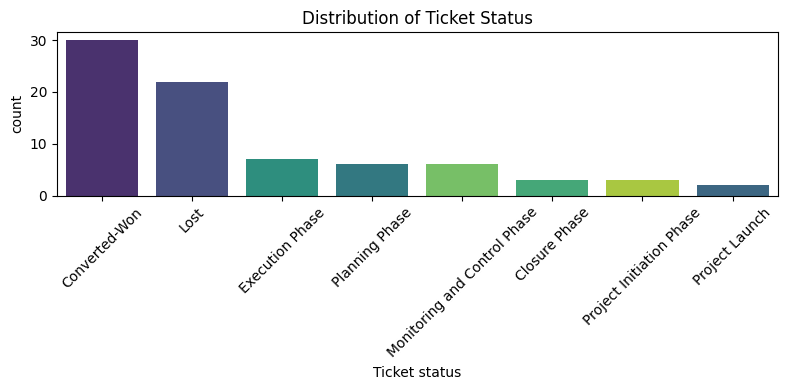

In [42]:
# Ticket status distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=tickets_df, x='Ticket status', order=tickets_df['Ticket status'].value_counts().index, hue='Ticket status', palette="viridis")
plt.title("Distribution of Ticket Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

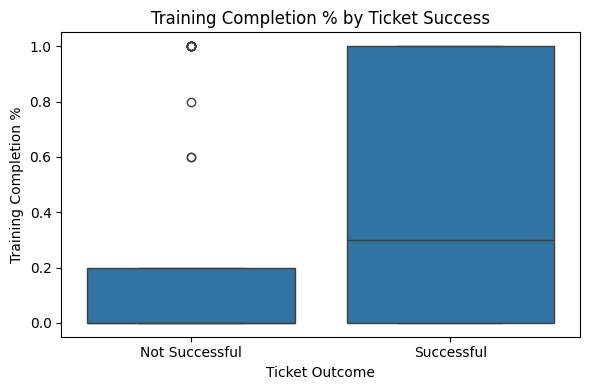

In [43]:
# Training Completion % by Ticket Success
plt.figure(figsize=(6, 4))
sns.boxplot(x='Is Successful', y='Training Completion %', data=tickets_df)
plt.title('Training Completion % by Ticket Success')
plt.xticks([0, 1], ['Not Successful', 'Successful'])
plt.xlabel("Ticket Outcome")
plt.ylabel("Training Completion %")
plt.tight_layout()
plt.show()

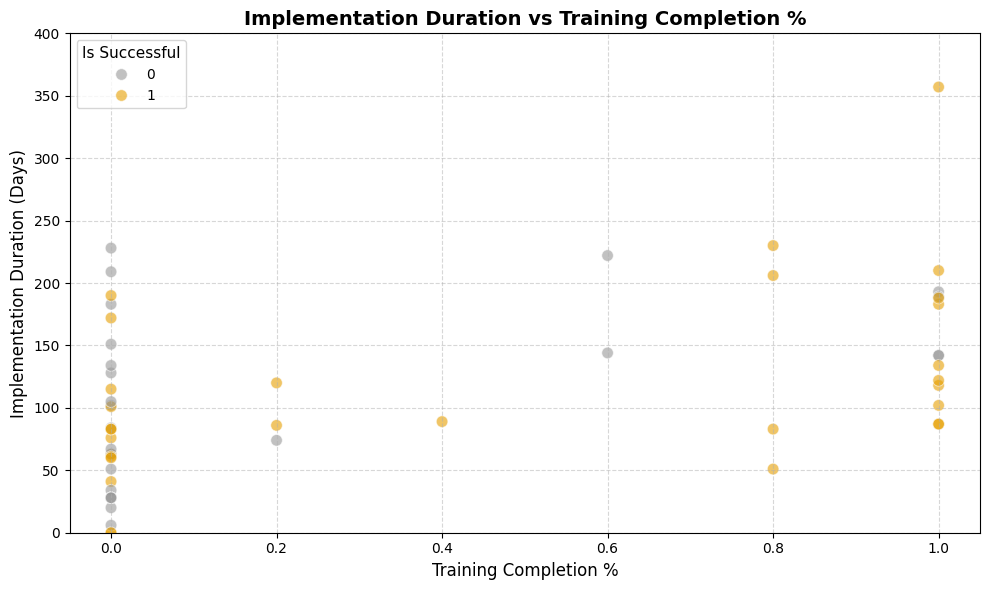

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tickets_df,
    x='Training Completion %',
    y='Implementation Duration Days',
    hue='Is Successful',
    palette={0: "#999999", 1: "#E69F00"},
    alpha=0.6,
    s=70
)
plt.title("Implementation Duration vs Training Completion %", fontsize=14, fontweight='bold')
plt.xlabel("Training Completion %", fontsize=12)
plt.ylabel("Implementation Duration (Days)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 400)
plt.legend(title='Is Successful', title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()

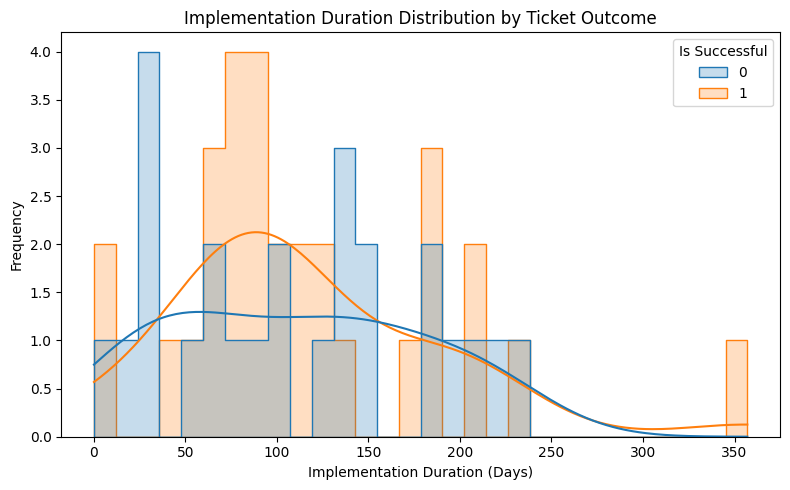

In [45]:
# Implementation Duration Distribution by Ticket Success
plt.figure(figsize=(8, 5))
sns.histplot(data=tickets_df, x='Implementation Duration Days', bins=30, hue='Is Successful', kde=True, element='step')
plt.title("Implementation Duration Distribution by Ticket Outcome")
plt.xlabel("Implementation Duration (Days)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Upsell Customer Analysis

In [47]:
with open('mappings.json', 'r') as f:
    mappings = json.load(f)
company_to_deals = mappings.get("CompanyToDeals", {})
mapping_list = []
for comp_id, deal_ids in company_to_deals.items():
    for deal_id in deal_ids:
        mapping_list.append({"Company_Record_ID": comp_id, "Deal_Record_ID": deal_id})
mapping_df = pd.DataFrame(mapping_list)

deals_df["Record ID"] = deals_df["Record ID"].astype(str)
mapping_df["Deal_Record_ID"] = mapping_df["Deal_Record_ID"].astype(str)

# Merge mapping DataFrame with deals data (assuming deals_df has a "Record ID" for each deal)
deals_with_company = pd.merge(mapping_df, deals_df, left_on="Deal_Record_ID", right_on="Record ID", how="inner")

In [48]:
# Filter deals where the Deal Type is "Upsell" (case-insensitive)
upsell_deals = deals_with_company[deals_with_company["Deal Type"] == "Growth"]

# Extract the unique Company_Record_IDs from the upsell deals
upsell_companies = upsell_deals["Company_Record_ID"].unique()

# Optionally, print the list of upsell company IDs for verification
print("Upsell company IDs:")
print(upsell_companies)

Upsell company IDs:
['9366136383' '9355871862' '16206048635' '14806346252' '10733490991'
 '10558217137' '11658771267' '9366092049' '18475337759' '9363073402'
 '11660991668' '9732328558' '9363076424' '12067836436' '16259826285'
 '12538423704' '9645904458' '9499343195' '29828266075' '10925369261'
 '10203327033' '9362275418' '29832756755' '9366069360' '9366155052'
 '9960233587' '9366059417' '29912622494' '15028171942' '9366087789'
 '9360792947' '9366168475' '29543474616']


In [50]:
# revert the company-ticket mapping
ticket_to_company = {}

for company_id, ticket_list in mappings["CompanyToTickets"].items():
    for ticket_id in ticket_list:
        ticket_to_company[ticket_id] = company_id

### convert the ticket id column into string type
tickets_df['Ticket ID'] = tickets_df['Ticket ID'].astype(str)
### create a company ID column in the tickets dataset based on 'ticket_to_company' dictionary
tickets_df['Company ID'] = tickets_df['Ticket ID'].map(ticket_to_company)
### filter the company dataset and only keep columns with less than 90% missing values, you can also try your own threshold
companies_df = companies_df.loc[:, companies_df.isnull().mean() < 0.9]
### convert the integer type into string type for later mapping
companies_df['Record ID'] = companies_df['Record ID'].astype(str)
merged_tickets = pd.merge(left = tickets_df, right= companies_df, left_on= 'Company ID', right_on = 'Record ID', how = 'left')

# Ensure that the company ID columns in merged_tickets and upsell_companies have matching types (as strings)
merged_tickets["Record ID"] = merged_tickets["Record ID"].astype(str)
upsell_companies = [str(x) for x in upsell_companies]

# Mark upsell customers: add a new column "Upsell_Customer" (True if company's Record ID is in upsell_companies, otherwise False)
merged_tickets["Upsell_Customer"] = merged_tickets["Record ID"].isin(upsell_companies)

In [51]:
# Define the training-related columns based on the data dictionary.
training_fields = [
    "Training: Sym Building 101",
    "Training: Sym Building 201",
    "Training: General Overview",
    "Training: Reporting",
    "Training: Deployment/User Management Training"
]

# Define a function to count how many training sessions are completed.
def count_trainings(row):
    count = 0
    # For each training field, if the value is not null and not empty, count it as completed.
    for col in training_fields:
        if pd.notnull(row[col]) and str(row[col]).strip() != "":
            count += 1
    return count

# Assuming merged_tickets is your DataFrame after merging tickets and companies,
# apply the function row-wise to add a new column 'Training_Completed_Count'.
merged_tickets["Training_Completed_Count"] = merged_tickets.apply(count_trainings, axis=1)

# Preview the training count
print("Merged tickets with Training Completed Count:")
merged_tickets[["Record ID"] + training_fields + ["Training_Completed_Count"]].head()

Merged tickets with Training Completed Count:


Record ID Training: Sym Building 101 Training: Sym Building 201  \
0  11466483988                        NaN                        NaN   
1  29543474616                        NaN                        NaN   
2  16275185826                 2024-12-23                 2024-12-23   
3  15851984185                 2023-07-11                 2023-08-01   
4  29965090080                        NaN                        NaN   

  Training: General Overview Training: Reporting  \
0                        NaN                 NaN   
1                        NaN                 NaN   
2                 2024-12-23          2024-12-23   
3                 2023-07-12          2023-07-19   
4                        NaN                 NaN   

  Training: Deployment/User Management Training  Training_Completed_Count  
0                                           NaN                         0  
1                                           NaN                         0  
2                                    2024-12-23                         5  
3                                    2023-07-19                         5  
4                                           NaN                         0

In [52]:
# Group the merged_tickets data by the company's "Record ID".
# For each company, we take the maximum training count seen among all of its tickets;
# this assumes that if any ticket indicates training completion, the company has completed it.
company_training = merged_tickets.groupby("Record ID").agg(
    Max_Training_Completed = pd.NamedAgg(column="Training_Completed_Count", aggfunc="max")
).reset_index()

# Preview the aggregated training data.
print("Aggregated Training Data by Company:")
print(company_training.head())

Aggregated Training Data by Company:
     Record ID  Max_Training_Completed
0  10203327033                       0
1  10558877741                       5
2  10733490991                       4
3  11466483988                       0
4  12549492871                       5


In [53]:
companies_with_training = pd.merge(merged_tickets, company_training, on="Record ID", how="left")
# Separate the companies into upsell and non-upsell groups based on the Upsell_Customer flag.
upsell_customers = companies_with_training[companies_with_training["Upsell_Customer"] == True]
non_upsell_customers = companies_with_training[companies_with_training["Upsell_Customer"] == False]

# Compute the average and median training completion count for each group.
avg_training_upsell = upsell_customers["Max_Training_Completed"].mean()
median_training_upsell = upsell_customers["Max_Training_Completed"].median()

avg_training_nonupsell = non_upsell_customers["Max_Training_Completed"].mean()
median_training_nonupsell = non_upsell_customers["Max_Training_Completed"].median()

print("Upsell customers - Average Training Completed Count: {:.2f}, Median: {}".format(avg_training_upsell, median_training_upsell))
print("Non-Upsell customers - Average Training Completed Count: {:.2f}, Median: {}".format(avg_training_nonupsell, median_training_nonupsell))

Upsell customers - Average Training Completed Count: 1.94, Median: 0.0
Non-Upsell customers - Average Training Completed Count: 2.26, Median: 1.0


In [54]:
# Convert key date fields to datetime format
date_fields = ["Trial Start Date", "Trial End Date", "Target Launch Date", "Stage Date - Project Launch"]
for field in date_fields:
    merged_tickets[field] = pd.to_datetime(merged_tickets[field], errors='coerce')

# Calculate the trial duration as the difference between Trial End Date and Trial Start Date (in days)
merged_tickets["Trial_Duration"] = (merged_tickets["Trial End Date"] - merged_tickets["Trial Start Date"]).dt.days

# Calculate the duration from the end of the trial to the target official launch (in days)
merged_tickets["Trial_to_Launch"] = (merged_tickets["Trial End Date"] - merged_tickets["Target Launch Date"]).dt.days

# Calculate the duration from the trial end to the project launch stage (in days)
merged_tickets["Launch_to_Execution"] = (merged_tickets["Stage Date - Project Launch"] - merged_tickets["Trial End Date"]).dt.days

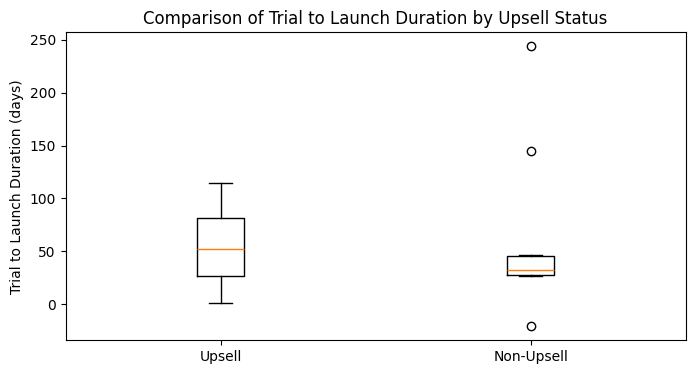

In [56]:
# If the Upsell_Customer flag exists, compare the Trial_to_Launch duration for Upsell and Non-Upsell customers using a boxplot
if "Upsell_Customer" in merged_tickets.columns:
    plt.figure(figsize=(8,4))
    data_to_plot = [
        merged_tickets[merged_tickets["Upsell_Customer"] == True]["Trial_to_Launch"].dropna(),
        merged_tickets[merged_tickets["Upsell_Customer"] == False]["Trial_to_Launch"].dropna()
    ]
    plt.boxplot(data_to_plot, tick_labels=["Upsell", "Non-Upsell"])
    plt.ylabel("Trial to Launch Duration (days)")
    plt.title("Comparison of Trial to Launch Duration by Upsell Status")
    plt.show()

## Data Cleaning

### Company

In [58]:
companies_df = pd.read_csv("data/anonymized_hubspot_companies.csv", low_memory=False)
companies_df.head()

CCaaS  Annual Revenue Associated Contact  Number of Form Submissions  \
0    NaN    1.000000e+09   Contact_ef780380                         0.0   
1    NaN             NaN   Contact_93373ba5                         NaN   
2    NaN    5.000000e+07   Contact_2e8e0993                         0.0   
3  Five9    5.000000e+07   Contact_635e44ed                         0.0   
4  Five9    1.000000e+08   Contact_8d055096                         0.0   

                                    Web Technologies  \
0                                           Route 53   
1                                                NaN   
2  Youtube; App Nexus; Google Tag Manager; Facebo...   
3  Postmark; Facebook Advertiser; Salesforce; Goo...   
4  Microsoft Office 365; Google Tag Manager; Reca...   

   Number of times contacted Contact with Primary Company ICP Fit Level  \
0                        5.0             Company_ef780380           NaN   
1                        NaN                          NaN           NaN   
2                        NaN             Company_2e8e0993           NaN   
3                        NaN             Company_635e44ed           NaN   
4                        NaN             Company_8d055096           NaN   

     Record ID         Time Zone  ... Consolidated Industry  \
0  25246439235  America/New_York  ...            (No value)   
1  22987081774               NaN  ...            (No value)   
2  22736642364  America/New_York  ...            (No value)   
3  22201736476  America/New_York  ...            (No value)   
4  22201510191   America/Chicago  ...            (No value)   

   Number of Employees  Primary Sub-Industry Number of Sessions  \
0               5000.0                   NaN                0.0   
1                  NaN                   NaN                NaN   
2                250.0                   NaN                0.0   
3                250.0                   NaN                0.0   
4               1000.0                   NaN                0.0   

  Country/Region                  Industry       Create Date  \
0  United States  HVAC and plumbing supply  2024-10-30 10:51   
1            NaN              Pest Control  2024-09-12 18:30   
2  United States              Pest Control  2024-09-03 10:44   
3  United States              Pest Control  2024-08-02 11:36   
4  United States              Pest Control  2024-08-02 11:36   

       Company name Last Modified Date Close YN  
0  Company_4fc73a2a   2025-02-14 13:39        N  
1  Company_f3f7e884   2025-02-14 13:39        N  
2  Company_89929bed   2025-02-14 13:39        N  
3  Company_33dbf591   2025-02-14 13:39        N  
4  Company_a3079821   2025-02-14 13:39        N  

[5 rows x 24 columns]

- Parent Company: NO
- CCaaS: YES, add one-hot encoding
- Annual Revenue: YES
- Target Account: YES, include 1 for True and 0 for False/empty
- Associated Contact: NO
- Number of Form Submissions: YES, but change to 1 for >0 and 0 for =0 because companies with deals closed had a lot of form submissions, new feature is Form Submission YN
- Total Agents: NO
- Web Technologies: Remove companies where this info is not available, add one-hot encoding
- Close Date: Turn into binary 0 and 1 values, new feature is Close YN (target)
- \# of Agents Total: NO, data not available for negative class
- Number of times contacted: YES and remove companies where this info is not available
- Contact with Primary Company: NO
- ICP Fit Level: YES, Include 1 for ideal fit and 0 for not ideal fit
- Revenue range: NO
- \# of Agents Contracted: NO
- Record ID: YES
- Time Zone: NO
- Primary Industry: YES, add one-hot encoding
- Number of Pageviews: YES, include 0 for empty
- Primary Company: NO
- Year Founded: NO
- ICP: NO, this is redundant with ICP Fit Level
- Industry group: NO
- Segmentation: NO
- LMS System: NO
- SymTrain Use Cases: NO
- Associated Company: NO
- BPO: YES, add "None" for empty values, turn into one-hot encoding
- SSO Application: NO
- State/Region: NO
- SymTrain Product: NO
- Contract End Date: NO
- SSO Implemented? NO
- Consolodated Industry: YES, set (No value) to null, one-hot encoded
- Type: YES, add one-hot encoding
- Number of Employees: YES
- BPO Program: NO, redundant with other fields
- Primary Sub-Industry: NO, redundant with Industry
- Number of Sessions: YES, include 0 for empty
- WFM: YES, add one-hot encoding
- Country/Region: YES, remove companies with no information, one-hot encoding
- Industry: YES, remove companies with no information, one-hot encoding
- Create Date: Extract year, month, and quarter as INTs, delete this column though
- Company name: NO
- Last Modified Date: NO
- BPO Program Tier: NO

In [65]:
companies_df = companies_df.dropna(subset=['Web Technologies'])

In [66]:
warnings.filterwarnings("ignore")
all_tools = set()

companies_df['Web Technologies'] = companies_df['Web Technologies'].apply(lambda x: x.split('; '))

for tools in companies_df['Web Technologies']:
    all_tools.update(tools)

for tool in all_tools:
    companies_df[f"Web Technologies_{tool}"] = companies_df['Web Technologies'].apply(lambda x: 1 if tool in x else 0)

companies_df = companies_df.drop(columns=['Web Technologies'])

In [67]:
companies_df = companies_df.drop(['Parent Company',
              'Associated Contact',
              'Total Agents',
              '# of Agents Total',
              'Contact with Primary Company',
              'Revenue range',
              '# of Agents Contracted',
              'Time Zone',
              'Primary Company',
              'Year Founded',
              'ICP',
              'Industry group',
              'Segmentation',
              'LMS System',
              'SymTrain Use Cases',
              'Associated Company',
              'SSO Application',
              'State/Region',
              'SymTrain Product',
              'Contract End Date',
              'SSO Implemented?',
              'BPO Program',
              'Primary Sub-Industry',
              'Company name',
              'Last Modified Date',
              'BPO Program Tier'], axis=1)

In [69]:
# CCaaS
ccaas_encoded = pd.get_dummies(companies_df['CCaaS'], prefix='CCaaS', dtype='int')
companies_df = companies_df.drop(columns=['CCaaS']).join(ccaas_encoded)

In [71]:
# Target Account
companies_df['Target Account'] = companies_df['Target Account'].fillna(False).astype(int)

In [70]:
# Number of Form Submissions
companies_df['Number of Form Submissions'] = companies_df['Number of Form Submissions'].fillna(0).astype(int)
companies_df['Form Submission YN'] = companies_df['Number of Form Submissions'].apply(lambda x: 1 if x > 0 else 0)
companies_df = companies_df.drop(columns=['Number of Form Submissions'])

In [72]:
# Number of times contacted
companies_df = companies_df.dropna(subset=['Number of times contacted'])
companies_df['Number of times contacted'] = companies_df['Number of times contacted'].astype(int)

In [73]:
# ICP Fit Level
companies_df['ICP Fit Level'] = np.where(companies_df['ICP Fit Level'] == 'Tier 1: Ideal Fit', 1, 0)

In [74]:
# Primary Industry
primary_industry_encoded = pd.get_dummies(companies_df['Primary Industry'], prefix='Primary Industry', dtype='int')
companies_df = companies_df.drop(columns=['Primary Industry']).join(primary_industry_encoded)

In [75]:
# Number of Pageviews
companies_df['Number of Pageviews'] = companies_df['Number of Pageviews'].fillna(0).astype(int)

In [76]:
# BPO
all_bpos = set()

companies_df['BPO'] = companies_df['BPO'].apply(lambda x: x.split('; ') if isinstance(x, str) else [])

for bpo in companies_df['BPO']:
    all_bpos.update(bpo)

for bpo in all_bpos:
    companies_df[f"BPO_{bpo}"] = companies_df['BPO'].apply(lambda x: 1 if isinstance(x, list) and bpo in x else 0)

companies_df = companies_df.drop(columns=['BPO'])

In [77]:
# Consolidated Industry
companies_df['Consolidated Industry'] = companies_df['Consolidated Industry'].replace("(No value)", np.nan)
consolidated_industry_encoded = pd.get_dummies(companies_df['Consolidated Industry'], prefix='Consolidated Industry', dtype='int')
companies_df = companies_df.drop(columns=['Consolidated Industry']).join(consolidated_industry_encoded)

In [78]:
# Type
type_encoded = pd.get_dummies(companies_df['Type'], prefix='Type', dtype='int')
companies_df = companies_df.drop(columns=['Type']).join(type_encoded)

In [79]:
# Number of Sessions
companies_df['Number of Sessions'] = companies_df['Number of Sessions'].fillna(0)
companies_df['Number of Sessions'] = companies_df['Number of Sessions'].astype(int)

In [80]:
# WFM
wfm_encoded = pd.get_dummies(companies_df['WFM'], prefix='WFM', dtype='int')
companies_df = companies_df.drop(columns=['WFM']).join(wfm_encoded)

In [81]:
# Country/Region
companies_df = companies_df.dropna(subset=['Country/Region'])
country_region_encoded = pd.get_dummies(companies_df['Country/Region'], prefix='Country/Region', dtype='int', drop_first=True)
companies_df = companies_df.drop(columns=['Country/Region']).join(country_region_encoded)

In [82]:
# Industry
industry_encoded = pd.get_dummies(companies_df['Industry'], prefix='Industry', dtype='int')
companies_df = companies_df.drop(columns=['Industry']).join(industry_encoded)

In [83]:
# Create Date
companies_df['Create Date'] = pd.to_datetime(companies_df['Create Date'])

companies_df['Create Date_Year'] = companies_df['Create Date'].dt.year
companies_df['Create Date_Month'] = companies_df['Create Date'].dt.month
companies_df['Create Date_Quarter'] = companies_df['Create Date'].dt.quarter
companies_df = companies_df.drop(columns=['Create Date'])

In [84]:
# Close YN (target)
companies_df['Close YN'] = np.where(companies_df['Close Date'].isna(), 0, 1)
companies_df = companies_df.drop(columns=['Close Date'])

Notes:
- The Record ID column will help map the datasets together, this feature should be removed when training the model
- The target variable predicting whether a deal is closed is called ‘Close YN’ and it is a 0/1 binary categorical variable

### Deal

In [89]:
deals_df = pd.read_csv("data/anonymized_hubspot_deals.csv")
deals_df.head()

Weighted amount                       Deal Description  \
0            250.0                        40-50 employees   
1              0.0                        3,000 + Agents.   
2              0.0                            5-6k agents   
3              0.0            Furthest Along - 300 agents   
4          10000.0  BPO through partnership with AmplifAI   

  Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss)  \
0                                                NaN                       
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

  Cumulative time in "Opportunity (Sales Pipeline)" (HH:mm:ss)  Days to close  \
0                                                NaN                     69.0   
1                                                NaN                    149.0   
2                                                NaN                    149.0   
3                                                NaN                    149.0   
4                                                NaN                    120.0   

   Deal Score        Close Date Deal source attribution 2  \
0        33.0  2025-05-01 15:26                     Event   
1        13.0  2025-07-20 09:06          Referral Partner   
2        13.0  2025-07-20 09:03          Referral Partner   
3        13.0  2025-07-20 08:55          Referral Partner   
4        37.0  2025-06-20 15:01              Master Agent   

  Cumulative time in "In Trial - Trial in Progress (Sales Pipeline)" (HH:mm:ss)  \
0                                                NaN                              
1                                                NaN                              
2                                                NaN                              
3                                                NaN                              
4                                                NaN                              

  Contract Start Date  ...  \
0                 NaN  ...   
1                 NaN  ...   
2                 NaN  ...   
3                 NaN  ...   
4                 NaN  ...   

  Cumulative time in "Negotiation (Sales Pipeline)" (HH:mm:ss)  \
0                                                NaN             
1                                                NaN             
2                                                NaN             
3                                                NaN             
4                                                NaN             

  Is Open (numeric)  \
0               1.0   
1               1.0   
2               1.0   
3               1.0   
4               1.0   

  Cumulative time in "Renewals  (Sales Pipeline)" (HH:mm:ss)  \
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           

        Create Date  \
0  2025-02-20 15:27   
1  2025-02-20 08:07   
2  2025-02-20 08:04   
3  2025-02-20 07:58   
4  2025-02-19 14:02   

   Cumulative time in "Contract Sent (Sales Pipeline)" (HH:mm:ss)  \
0                                                NaN                
1                                                NaN                
2                                                NaN                
3                                                NaN                
4                                                NaN                

  Total contract value Last Modified Date  \
0                  NaN   2025-02-20 16:28   
1                  NaN   2025-02-20 09:08   
2                  NaN   2025-02-20

- Weighted amount: YES
- Deal Description: NO
- Cumulative time in "BANT Deal. Pain ID'ed (Sales Pipeline)" (HH:mm:ss): NO
- Cumulative time in "Opportunity (Sales Pipeline)" (HH:mm:ss) NO
- Days to close: Yes
- Deal Score: YES
- Close Date: Yes
- Deal source attribution 2: YES, add one-hot encoding
- Cumulative time in "In Trial - Trial in Progress (Sales Pipeline)" (HH:mm:ss): NO
- Contract Start Date: NO
- Cumulative time in "Partner Referrals  (Sales Pipeline)" (HH:mm:ss): NO
- Cumulative time in "Closed Lost (Sales Pipeline)" (HH:mm:ss): NO
- Cumulative time in "Deep Dive. PSP Drafted (Sales Pipeline)" (HH:mm:ss): NO
- Pipeline: NO
- Record ID: YES
- Forecast category: YES, add one-hot encoding
- Original Traffic Source: YES, add one-hot encoding
- Associated Company: NO
- Deal owner: NO
- Annual contract value: NO
- Is Closed (numeric): NO, we have deal stage
- Amount in company currency: NO, redundant of Amount
- Annual recurring revenue: NO
- Monthly recurring revenue: NO
- Deal probability: YES
- Associated Company (Primary): NO
- Is Closed Won: YES, convert to 0/1 binary
- Forecast probability: NO
- Contract End Date: NO
- Last Activity Date: NO
- Contract Term (Months): NO
- Trial Start date: NO
- Is closed lost: YES, convert to 0/1 binary
- Weighted amount in company currency: NO, redundant of Weighted amount
- Is Deal Closed?: NO
- Trial End Date: NO
- Deal Name: NO
- Amount: YES
- Cumulative time in "Closed Trial (Sales Pipeline)" (HH:mm:ss): NO
- Forecast amount: NO, redundant of amount
- Cumulative time in "Negotiation (Sales Pipeline)" (HH:mm:ss): NO
- Is Open (numeric): NO, we have deal stage and closed win/lost
- Cumulative time in "Renewals  (Sales Pipeline)" (HH:mm:ss): NO
- Create Date: Get other data from this value and then delete
- Cumulative time in "Contract Sent (Sales Pipeline)" (HH:mm:ss): NO
- Total contract value: NO
- Last Modified Date: NO
- Cumulative time in "Closed Won (Sales Pipeline)" (HH:mm:ss): NO
- Deal Stage: YES, categorical label encoding
- Deal Type: YES, one-hot encoding

In [90]:
deals_df = deals_df.drop(["Deal Description",
                          "Cumulative time in \"BANT Deal. Pain ID'ed (Sales Pipeline)\" (HH:mm:ss)",
                          "Cumulative time in \"Opportunity (Sales Pipeline)\" (HH:mm:ss)",
                          "Cumulative time in \"In Trial - Trial in Progress (Sales Pipeline)\" (HH:mm:ss)",
                          "Contract Start Date",
                          "Cumulative time in \"Partner Referrals  (Sales Pipeline)\" (HH:mm:ss)",
                          "Cumulative time in \"Closed Lost (Sales Pipeline)\" (HH:mm:ss)",
                          "Cumulative time in \"Deep Dive. PSP Drafted (Sales Pipeline)\" (HH:mm:ss)",
                          "Pipeline",
                          "Associated Company",
                          "Deal owner",
                          "Annual contract value",
                          "Is Closed (numeric)",
                          "Amount in company currency",
                          "Annual recurring revenue",
                          "Monthly recurring revenue",
                          "Associated Company (Primary)",
                          "Forecast probability",
                          "Contract End Date",
                          "Contract Term (Months)",
                          "Trial Start date",
                          "Weighted amount in company currency",
                          "Is Deal Closed?",
                          "Trial End Date",
                          "Deal Name",
                          "Cumulative time in \"Closed Trial (Sales Pipeline)\" (HH:mm:ss)",
                          "Forecast amount",
                          "Cumulative time in \"Negotiation (Sales Pipeline)\" (HH:mm:ss)",
                          "Is Open (numeric)",
                          "Cumulative time in \"Renewals  (Sales Pipeline)\" (HH:mm:ss)",
                          "Cumulative time in \"Contract Sent (Sales Pipeline)\" (HH:mm:ss)",
                          "Total contract value",
                          "Cumulative time in \"Closed Won (Sales Pipeline)\" (HH:mm:ss)"], axis=1)

In [91]:
# Deal source attribution 2
dsa_2_encoded = pd.get_dummies(deals_df['Deal source attribution 2'], prefix='Deal source attribution 2', dtype='int')
deals_df = deals_df.drop(columns=['Deal source attribution 2']).join(dsa_2_encoded)

In [92]:
# Forecast category
forecast_cat_encoded = pd.get_dummies(deals_df['Forecast category'], prefix='Forecast category', dtype='int', drop_first=True)
deals_df = deals_df.drop(columns=['Forecast category']).join(forecast_cat_encoded)

In [93]:
# Original Traffic Source
orig_traf_encoded = pd.get_dummies(deals_df['Original Traffic Source'], prefix='Original Traffic Source', dtype='int', drop_first=True)
deals_df = deals_df.drop(columns=['Original Traffic Source']).join(orig_traf_encoded)

In [94]:
# Is Closed Won
deals_df['Is Closed Won'] = deals_df['Is Closed Won'].astype(int)

In [95]:
# Is Closed lost
deals_df['Is closed lost'] = deals_df['Is closed lost'].astype(int)

In [96]:
# Create Date
deals_df['Create Date'] = pd.to_datetime(deals_df['Create Date'])
deals_df['Close Date'] = pd.to_datetime(deals_df['Close Date'])
deals_df['Close Date'] = deals_df['Close Date'].fillna(deals_df['Last Activity Date']).fillna(deals_df['Create Date'])

In [97]:
# Deal Stage
deal_stage_mapping = {
    "Partner Referrals ": 1,
    "Opportunity": 2,
    "BANT Deal. Pain ID'ed": 3,
    "Negotiation": 4,
    "Deep Dive. PSP Drafted": 5,
    "Contract Sent": 6,
    "Closed Won": 7,
    "Closed Lost": 7,
    "Closed Trial": 7,
    "Renewals ": 8,
    "In Trial - Trial in Progress": 9
}

deals_df["Deal Stage Categorical"] = deals_df["Deal Stage"].map(deal_stage_mapping)
deals_df["Deal Stage"] = deals_df["Deal Stage Categorical"].astype(int)
deals_df = deals_df.drop(columns=['Deal Stage Categorical'])

In [98]:
# Deal Type
deal_type_encoded = pd.get_dummies(deals_df['Deal Type'], prefix='Deal Type', dtype='int', drop_first=True)
deals_df = deals_df.drop(columns=['Deal Type']).join(deal_type_encoded)

In [136]:
deals_df['Deal Score'].fillna(0, inplace=True)
deals_df['Last Activity Date'].fillna(deals_df['Last Modified Date'], inplace=True)

In [142]:
deals_df = deals_df.dropna(subset=['Amount'])

Notes:
- The Record ID column will help map the datasets together, this feature should be removed when training the model
- The target variable for predicting whether a deal is closed and won is called ‘Is Closed Won’ and it is a 0/1 binary categorical variable
    - Equaling 0 does not necessarily mean it's a loss, the deal could be in trial

### Ticket

In [101]:
tickets_df = pd.read_csv("data/anonymized_hubspot_tickets.csv")
tickets_df.head()

Create date  Ticket Tags Stage Date - Project Launch  \
0  2023-12-18 15:02          NaN                         NaN   
1  2024-10-30 12:31          NaN                         NaN   
2  2024-12-12 09:01          NaN                  2025-01-10   
3  2023-09-07 16:37          NaN                         NaN   
4  2025-02-14 13:34          NaN                         NaN   

  Associated Contact  Category Target Launch Date Kickoff Call  \
0   Contact_b6d930b5       NaN                NaN   2023-12-27   
1   Contact_aa84b2e1       NaN                NaN          NaN   
2   Contact_fec7b624       NaN                NaN   2024-12-10   
3   Contact_11c92d4d       NaN         2023-10-02   2023-06-08   
4   Contact_78b60b6b       NaN                NaN          NaN   

         Close date              Pipeline Stage Date - Project Initiation  \
0  2024-01-29 11:50  Project Success Plan                      2023-12-18   
1  2025-02-10 11:18  Project Success Plan                             NaN   
2               NaN  Project Success Plan                      2024-12-13   
3  2024-01-04 13:28  Project Success Plan                             NaN   
4               NaN  Project Success Plan                      2025-02-14   

   ...  Latest Milestone Update Date      Ticket name  \
0  ...                           NaN  Ticket_4baf7886   
1  ...                           NaN  Ticket_88dda9e1   
2  ...                           NaN  Ticket_2226dda1   
3  ...                    2023-11-24  Ticket_6c996e04   
4  ...                           NaN  Ticket_14c6e9a9   

                                      Trial Overview Trial Start Date  \
0                                                NaN              NaN   
1                                                NaN       2024-11-05   
2                           Trial until end of April       2024-12-11   
3  Coaching already implemented, adding onboardin...              NaN   
4                                                NaN              NaN   

   1st Syms presented for review Project Launch Day Training: Reporting  \
0                            NaN                NaN                 NaN   
1                            NaN                NaN                 NaN   
2                     2024-12-23         2025-01-06          2024-12-23   
3                            NaN         2023-06-14          2023-07-19   
4                            NaN                NaN                 NaN   

  Construction of 1st Sym begun Trial Required  Was the sym QAed?  
0                    2023-12-27            NaN                NaN  
1                           NaN            NaN                NaN  
2                    2024-12-11            NaN                NaN  
3                           NaN            NaN                NaN  
4                           NaN            NaN                NaN  

[5 rows x 46 columns]

- Create date: Get other data from this value, but then delete
- Ticket Tags: NO
- Stage Date - Project Launch: NO
- Associated Contact: NO
- Category: NO
- Target Launch Date: NO
- Kickoff Call: NO
- Close date: Delete missing values, get other data from this value, but then delete
- Pipeline: NO
- Stage Date - Project Initiation: NO
- Stage Date - Planning Phase: NO
- Ticket status: YES, add one-hot encoding, numbers are assigned to each stage and a one-hot encoding is assigned for a win or loss (Ticket status_Won and Ticket status_Lost)
- Stage Date - Execution: NO
- Time to first agent email reply (HH:mm:ss): NO, this is duplicate data from Response time (HH:mm:ss)
- Last CES survey rating: NO
- Priority: NO
- Associated Company: NO
- Who will be creating the Syms?: NO
- Stage Date - Closure Phase: NO
- Stage Date - Monitoring and Control Phase: NO
- Associated Company (Primary): NO
- Response time (HH:mm:ss): YES, convert to hours as Response time hours
- Ticket ID: YES
- Time to close (HH:mm:ss): NO, data only present for closed tickets
- Associated Deal: NO
- Library index approved: NO
- Training: General Overview: Get other data from this value (count if date is present, don't if date is not), but then delete
- Latest Milestone: NO
- Training: Deployment/User Management Training: Get other data from this value (count if date is present, don't if date is not), but then delete
- Requirements for the Trial: YES, one-hot encoding
- Training: Sym Building 101: Get other data from this value (count if date is present, don't if date is not), but then delete
- Last modified date: NO
- Type: NO
- Trial End Date: NO
- Training: Sym Building 201: Get other data from this value (count if date is present, don't if date is not), but then delete
- Stage Date - Converted Won: NO
- Latest Milestone Update Date: NO
- Ticket name: NO
- Trial Overview: NO
- Trial Start Date: NO
- 1st Syms presented for review: NO
- Project Launch Day: NO
- Training: Reporting: Get other data from this value (count if date is present, don't if date is not), but then delete
- Construction of 1st Sym begun: NO
- Trial Required: NO
- Was the sym QAed?: NO

In [102]:
tickets_df = tickets_df.drop(['Ticket Tags',
                              'Stage Date - Project Launch',
                              'Associated Contact',
                              'Category',
                              'Target Launch Date',
                              'Kickoff Call',
                              'Pipeline',
                              'Stage Date - Project Initiation',
                              'Stage Date - Planning Phase',
                              'Stage Date - Execution',
                              'Time to first agent email reply (HH:mm:ss)',
                              'Last CES survey rating',
                              'Priority',
                              'Associated Company',
                              'Who will be creating the Syms?',
                              'Stage Date - Closure Phase',
                              'Stage Date - Monitoring and Control Phase',
                              'Associated Company (Primary)',
                              'Associated Deal',
                              'Library index approved',
                              'Latest Milestone',
                              'Last modified date',
                              'Type',
                              'Stage Date - Converted Won',
                              'Latest Milestone Update Date',
                              'Ticket name',
                              'Trial Overview',
                              '1st Syms presented for review',
                              'Project Launch Day',
                              'Construction of 1st Sym begun',
                              'Trial Required',
                              'Was the sym QAed?',
                              'Trial Start Date',
                              'Trial End Date',
                              'Time to close (HH:mm:ss)'], axis=1)

In [103]:
# Create date
tickets_df['Create date'] = pd.to_datetime(tickets_df['Create date'])

tickets_df['Create date_Year'] = tickets_df['Create date'].dt.year
tickets_df['Create date_Month'] = tickets_df['Create date'].dt.month
tickets_df['Create date_Quarter'] = tickets_df['Create date'].dt.quarter

In [104]:
# Close date/Implementation Duration Days
tickets_df['Close date'] = pd.to_datetime(tickets_df['Close date'])
tickets_df['Implementation Duration Days'] = (tickets_df['Close date'] - tickets_df['Create date']).dt.days

tickets_df = tickets_df.drop(columns=['Create date', 'Close date'])

In [105]:
status_order = {
    "Project Initiation Phase": 1,
    "Planning Phase": 2,
    "Project Launch": 3,
    "Execution Phase": 4,
    "Monitoring and Control Phase": 5,
    "Closure Phase": 6,
    "Converted-Won": 7,
    "Lost": 7
}

tickets_df["Status Order"] = tickets_df["Ticket status"].map(status_order)

tickets_df["Ticket status_Won"] = tickets_df["Ticket status"].apply(lambda x: 1 if x == "Converted-Won" else 0)
tickets_df["Ticket status_Lost"] = tickets_df["Ticket status"].apply(lambda x: 1 if x == "Lost" else 0)

tickets_df["Ticket status"] = tickets_df["Status Order"]
tickets_df = tickets_df.drop(columns=['Status Order'])

In [106]:
# Response time
tickets_df = tickets_df.dropna(subset=['Response time (HH:mm:ss)'])

tickets_df['Response time (HH:mm:ss)'] = pd.to_timedelta(tickets_df['Response time (HH:mm:ss)'])

tickets_df["Response time hours"] = tickets_df['Response time (HH:mm:ss)'].dt.total_seconds() / 3600

tickets_df = tickets_df.drop(columns=['Response time (HH:mm:ss)'])

In [107]:
# All training columns
training_columns = ['Training: General Overview',
                    'Training: Deployment/User Management Training',
                    'Training: Sym Building 101',
                    'Training: Sym Building 201',
                    'Training: Reporting']

tickets_df["Training Completion Count"] = tickets_df[training_columns].notna().sum(axis=1)

tickets_df = tickets_df.drop(columns=training_columns)

In [108]:
# Requirements for the Trial
all_reqs = set()

tickets_df['Requirements for the Trial'] = tickets_df['Requirements for the Trial'].apply(lambda x: x.split('; ') if isinstance(x, str) else [])

for req in tickets_df['Requirements for the Trial']:
    all_reqs.update(req)

for req in all_reqs:
    tickets_df[f"Requirements for the Trial_{req}"] = tickets_df['Requirements for the Trial'].apply(lambda x: 1 if isinstance(x, list) and req in x else 0)

tickets_df = tickets_df.drop(columns=['Requirements for the Trial'])

Notes:
- The Ticket ID column will help map the datasets together, this feature should be removed when training the model
- The target variable for predicting whether a ticket is closed and won is called ‘Ticket status_Won’ and it is a 0/1 binary categorical variable
    - Equaling 0 does not necessarily mean it's a loss, the ticket still could be in process

## Customer Segmentation

### Feature Engineering

In [110]:
cdf = companies_df.copy()
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10874 entries, 0 to 19850
Columns: 998 entries, Annual Revenue to Close YN
dtypes: float64(3), int32(3), int64(992)
memory usage: 82.8 MB


After one-hot encoding, the companies dataset has 998 columns, so it's necessary to perform dimensionality reduction before building the model.

In [112]:
# Drop some columns if present
if "Record ID" in cdf.columns:
    cdf = cdf.drop(columns=["Record ID"])

In [113]:
# Extract features and target
X = cdf.drop(columns=["Close YN"])
y = cdf["Close YN"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

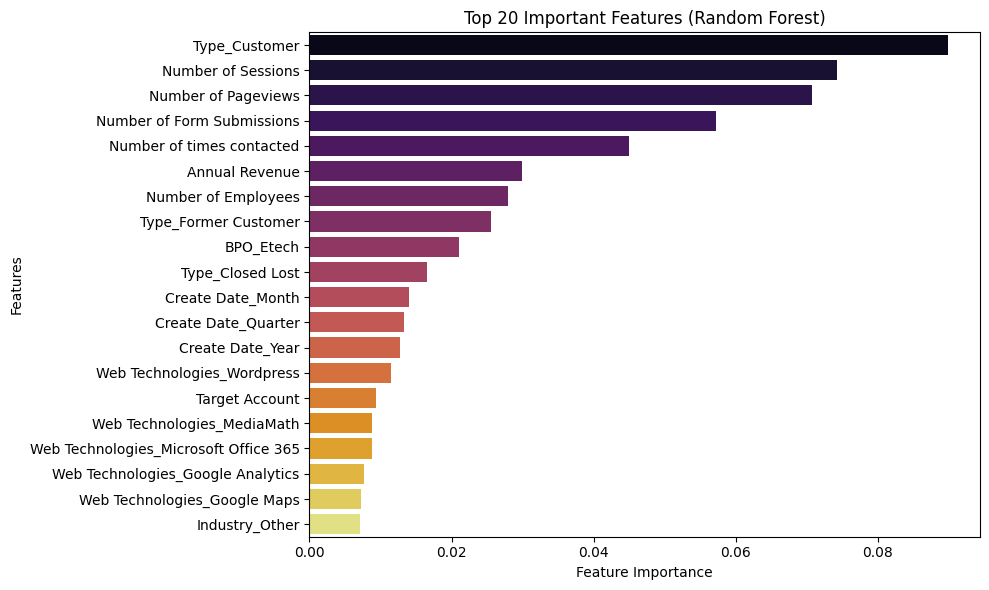

In [114]:
# Train RandomForest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Top 20 features
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

# Plot top 20 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue = top_features.index, palette="inferno")
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Clustering & Visualization

In [125]:
# Select top features used earlier
cdf = cdf.dropna()
X_cluster = cdf[top_features.index].copy()

# Standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

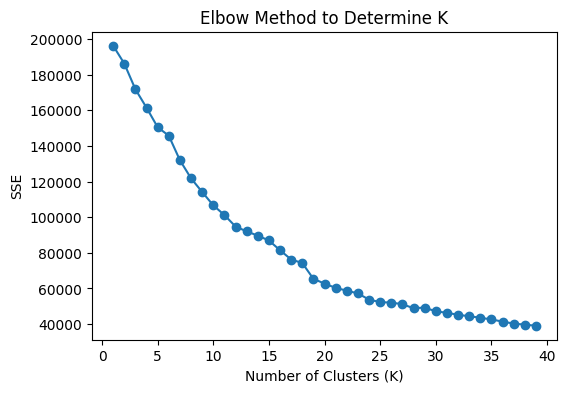

In [126]:
sse = []
K_range = range(1, 40)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, sse, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.title("Elbow Method to Determine K")
plt.show()

In [127]:
# Fit KMeans models
kmeans_5 = KMeans(n_clusters=5, random_state=42)
cdf["Cluster_K5"] = kmeans_5.fit_predict(X_scaled)

kmeans_19 = KMeans(n_clusters=19, random_state=42)
cdf["Cluster_K19"] = kmeans_19.fit_predict(X_scaled)

In [128]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster_K5"] = cdf["Cluster_K5"]
pca_df["Cluster_K19"] = cdf["Cluster_K19"]

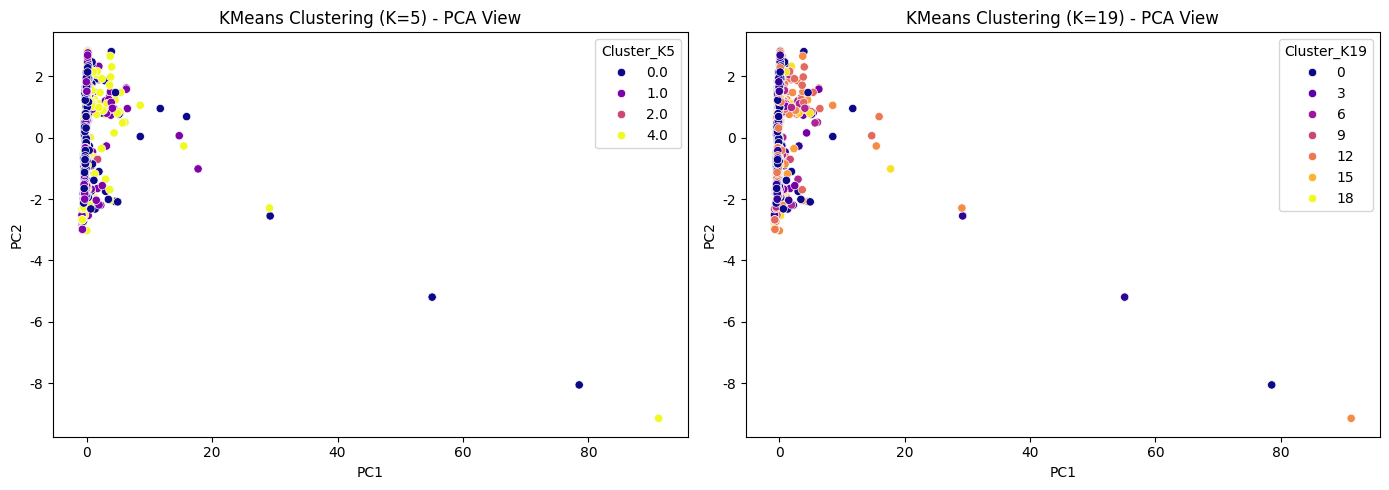

In [129]:
# Plot the PCA views for K=5 and K=19
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster_K5", palette="plasma", ax=axes[0])
axes[0].set_title("KMeans Clustering (K=5) - PCA View")

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster_K19", palette="plasma", ax=axes[1])
axes[1].set_title("KMeans Clustering (K=19) - PCA View")

plt.tight_layout()
plt.show()

In [130]:
# Analyze Close YN and ICP Fit Level distribution in K=4 clusters
close_dist = cdf.groupby("Cluster_K5")["Close YN"].value_counts(normalize=True).unstack()

if "ICP Fit Level" in companies_df.columns:
    icp_dist = cdf.groupby("Cluster_K5")["ICP Fit Level"].value_counts(normalize=True).unstack()
else:
    icp_dist = None

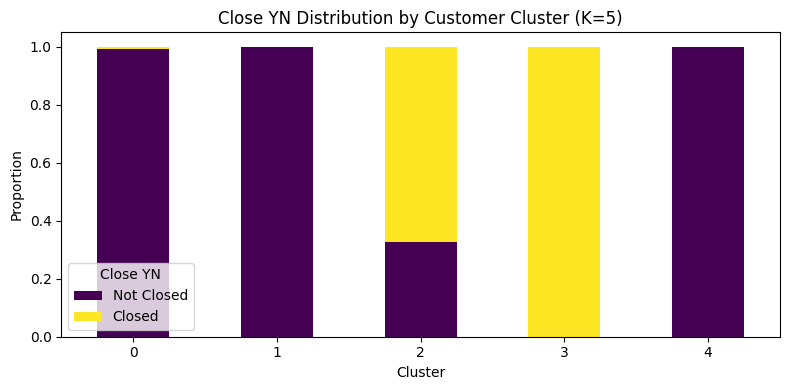

In [131]:
# Plot Close YN Distribution
close_dist.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 4))
plt.title("Close YN Distribution by Customer Cluster (K=5)")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(title="Close YN", labels=["Not Closed", "Closed"])
plt.tight_layout()
plt.show()

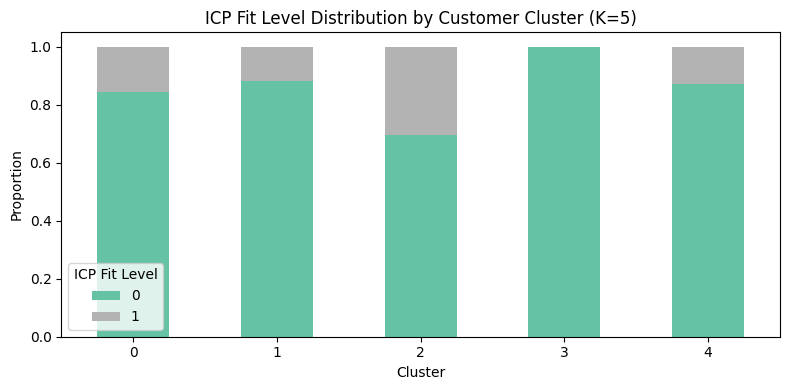

In [132]:
# Plot ICP Fit Level Distribution if available
if icp_dist is not None:
    icp_dist.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 4))
    plt.title("ICP Fit Level Distribution by Customer Cluster (K=5)")
    plt.ylabel("Proportion")
    plt.xlabel("Cluster")
    plt.xticks(rotation=0)
    plt.legend(title="ICP Fit Level")
    plt.tight_layout()
    plt.show()

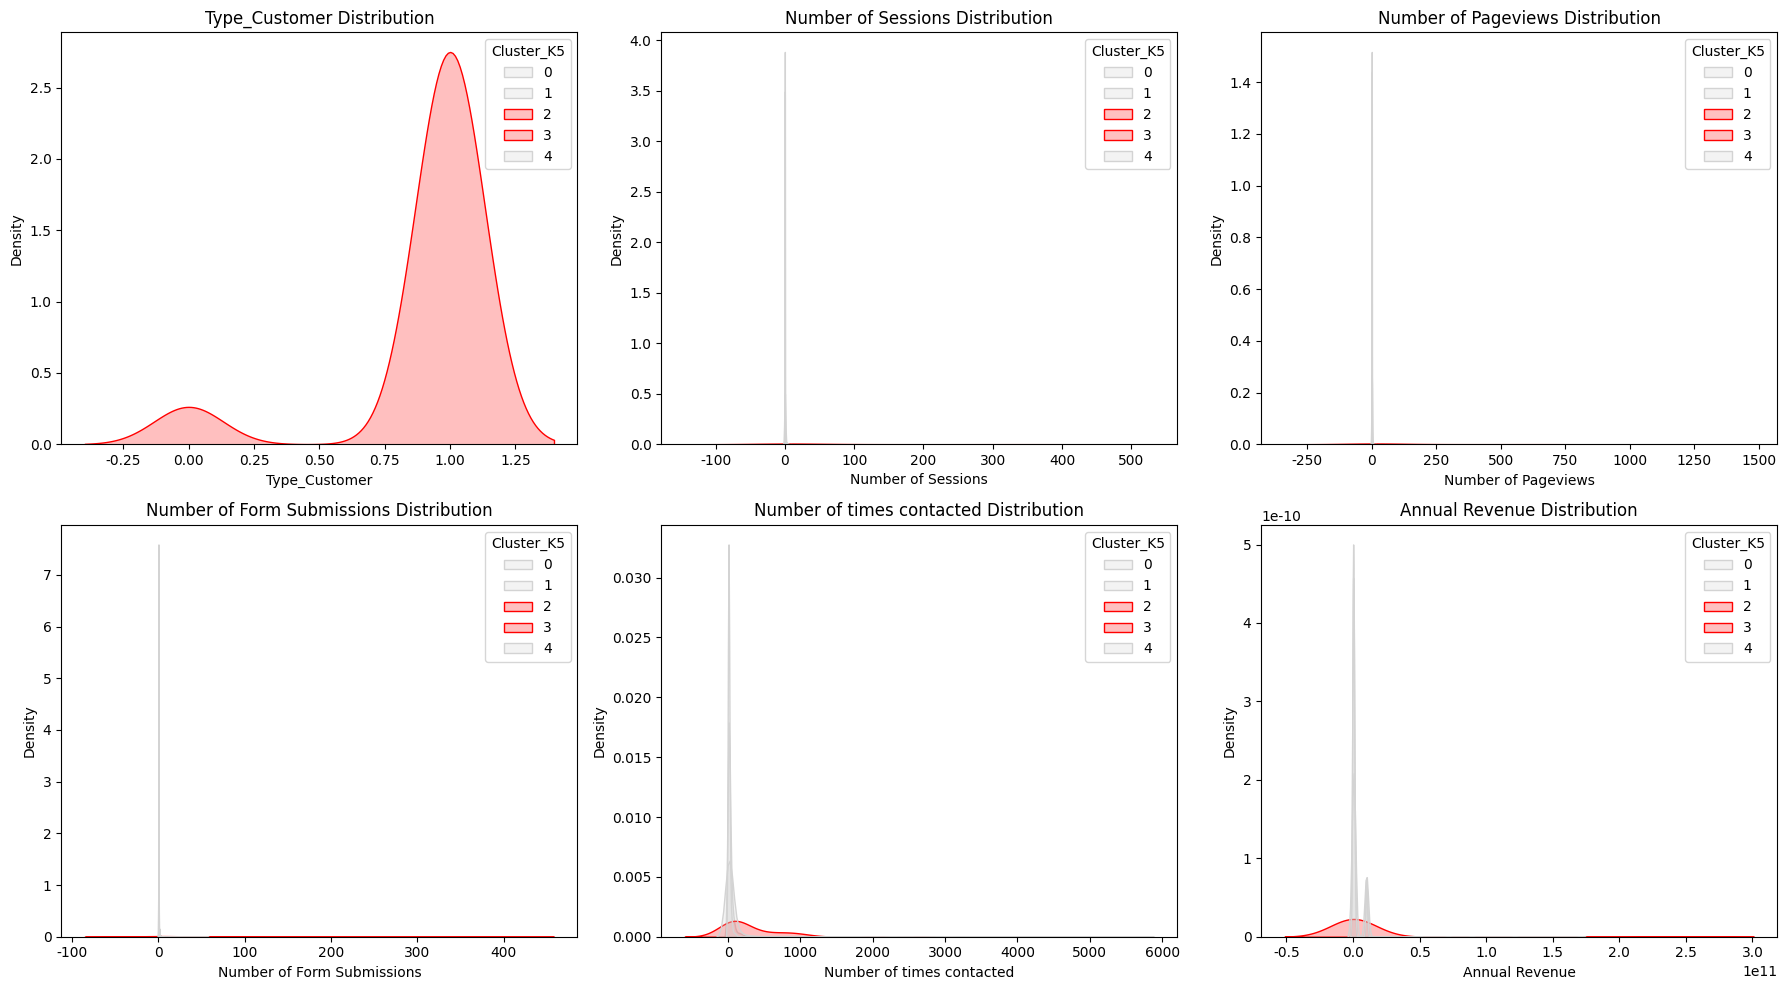

In [134]:
# Visualize important features distribution in Cluster 2 vs other clusters
important_features = top_features.index[:6]  # Select top 6 features for visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
palette = {0: "lightgray", 1: "lightgray", 2: "red", 3: "red", 4: "lightgray"}

for i, feature in enumerate(important_features):
    row = i // 3
    col = i % 3
    sns.kdeplot(
        data=cdf,
        x=feature,
        hue="Cluster_K5",
        fill=True,
        common_norm=False,
        palette=palette,
        ax=axes[row, col],
        warn_singular=False
    )
    axes[row, col].set_title(f"{feature} Distribution")
    
plt.tight_layout()
plt.show()

### RFM

In [143]:
company_to_deals = mappings.get("CompanyToDeals", {})
for key, value in list(company_to_deals.items())[:5]:
    print(f"Company Record ID: {key} --> Deal Record IDs: {value}")

Company Record ID: 17771181752 --> Deal Record IDs: ['29547238775']
Company Record ID: 9364308545 --> Deal Record IDs: ['9794988112']
Company Record ID: 9366087515 --> Deal Record IDs: ['9817334075']
Company Record ID: 9366136383 --> Deal Record IDs: ['9817334090']
Company Record ID: 9366140751 --> Deal Record IDs: ['9817320072']


In [144]:
# Expand the mapping dictionary into a list of (Company_Record_ID, Deal_Record_ID) pairs
mapping_list = []
for company_id, deal_list in company_to_deals.items():
    for deal_id in deal_list:
        mapping_list.append({"Company_Record_ID": company_id, "Deal_Record_ID": deal_id})

# Convert the list to a DataFrame
mapping_df = pd.DataFrame(mapping_list)

# Preview the mapping DataFrame
print("Mapping DataFrame preview:")
print(mapping_df.head())

Mapping DataFrame preview:
  Company_Record_ID Deal_Record_ID
0       17771181752    29547238775
1        9364308545     9794988112
2        9366087515     9817334075
3        9366136383     9817334090
4        9366140751     9817320072


In [145]:
# Merge the mapping DataFrame with deals data based on the deal identifier
# mapping_df.Deal_Record_ID should match deals_df['Record ID'] (which is the deal's unique ID)
deals_df["Record ID"] = deals_df["Record ID"].astype(str)
mapping_df["Deal_Record_ID"] = mapping_df["Deal_Record_ID"].astype(str)
deals_with_company = pd.merge(mapping_df, deals_df, left_on="Deal_Record_ID", right_on="Record ID", how="inner")

In [146]:
# Group the merged deals data by the company (using the mapping field 'Company_Record_ID')
# and calculate aggregate metrics for each company.
deals_agg = deals_with_company.groupby("Company_Record_ID").agg(
    Total_Deals_Count=pd.NamedAgg(column="Record ID", aggfunc="count"),
    Total_Deal_Amount=pd.NamedAgg(column="Amount", aggfunc="sum"),
    Average_Deal_Amount=pd.NamedAgg(column="Amount", aggfunc="mean"),
    Win_Rate=pd.NamedAgg(column="Is Closed Won", aggfunc="mean"),
    Average_Days_to_Close=pd.NamedAgg(column="Days to close", aggfunc="mean"),
    Last_Close_Date=pd.NamedAgg(column="Close Date", aggfunc="max")
).reset_index()

current_date = pd.to_datetime("today")
deals_agg["Recency"] = (current_date - pd.to_datetime(deals_agg["Last_Close_Date"])).dt.days
deals_agg.drop(columns=["Last_Close_Date"], inplace=True)
# Preview the aggregated metrics
print("Aggregated deals metrics by company:")
deals_agg.info()

Aggregated deals metrics by company:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company_Record_ID      329 non-null    object 
 1   Total_Deals_Count      329 non-null    int64  
 2   Total_Deal_Amount      329 non-null    float64
 3   Average_Deal_Amount    329 non-null    float64
 4   Win_Rate               329 non-null    float64
 5   Average_Days_to_Close  329 non-null    float64
 6   Recency                329 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 18.1+ KB


In [147]:
# Frequency is computed as the total number of deals per company (Total_Deals_Count).
# Monetary is computed as the total transaction amount per company (Total_Deal_Amount).
# For RFM analysis, we use quantile-based scoring (1-5 scale).

# Score Recency: lower recency (fewer days) is better. 
# Therefore, assign higher scores to lower Recency values.
deals_agg["R_Score"] = pd.qcut(deals_agg["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Score Frequency: higher number of deals is better.
def assign_score(total_deals):
    if total_deals == 1:
        return 1
    elif 1 < total_deals <= 10:
        return 3
    else:  # total_deals > 10
        return 5

deals_agg["F_Score"] = deals_agg["Total_Deals_Count"].apply(assign_score)

# Score Monetary: higher total amount is better.
deals_agg["M_Score"] = pd.qcut(deals_agg["Total_Deal_Amount"], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Calculate overall RFM Score by summing individual scores.
deals_agg["RFM_Score"] = deals_agg["R_Score"] + deals_agg["F_Score"] + deals_agg["M_Score"]

In [148]:
# Calculate the 80th percentile (i.e., top 20% threshold) of the RFM_Score column.
threshold = deals_agg["RFM_Score"].quantile(0.8)

# Filter companies with RFM_Score greater than or equal to the threshold.
top_20_percent_customers = deals_agg[deals_agg["RFM_Score"] >= threshold]

# Preview the filtered results.
print("Top 20% customers based on RFM_Score:")
top_20_percent_customers

Top 20% customers based on RFM_Score:


Company_Record_ID  Total_Deals_Count  Total_Deal_Amount  \
4         10203327033                  3           111800.0   
28        10558210732                  1           144000.0   
29        10558217137                  3           216000.0   
32        10558847651                  2            48000.0   
34        10558856614                  1            90000.0   
..                ...                ...                ...   
302        9366168187                  1           100000.0   
304        9366168475                  6           215000.0   
309        9499343195                  7            65000.0   
310        9645904458                  7           205000.0   
323        9960233587                  5            51600.0   

     Average_Deal_Amount  Win_Rate  Average_Days_to_Close  Recency  R_Score  \
4           37266.666667  0.666667             137.000000      -39        5   
28         144000.000000  0.000000             108.000000       68        4   
29          72000.000000  0.000000             279.666667       25        5   
32          24000.000000  0.000000             213.000000      105        4   
34          90000.000000  0.000000             113.000000       34        5   
..                   ...       ...                    ...      ...      ...   
302        100000.000000  0.000000             149.000000      -20        5   
304         35833.333333  0.333333             107.500000      476        2   
309          9285.714286  0.857143             137.857143      207        3   
310         29285.714286  0.428571             151.428571       22        5   
323         10320.000000  0.400000             223.200000      177        3   

     F_Score  M_Score  RFM_Score  
4          3        5         13  
28         1        5         10  
29         3        5         13  
32         3        3         10  
34         1        5         11  
..       ...      ...        ...  
302        1        5         11  
304        3        5         10  
309        3        4         10  
310        3        5         13  
323        3        4         10  

[77 rows x 11 columns]

Our approach leverages RFM analysis—a widely recognized technique that segments customers based on three key dimensions:
Recency (R): This measures how recently a customer made their last transaction. A lower number of days since the last purchase indicates that the customer is still engaged and active with our brand. In our model, we score Recency inversely (i.e., the lower the number, the higher the score).
Frequency (F): This reflects the total number of purchases made by a customer. A higher transaction frequency suggests greater customer loyalty and engagement. In our implementation, we either score this directly by quantiles or by applying a custom rule (e.g., customers with more than 10 transactions receive the highest score).
Monetary (M): This represents the total amount spent by the customer over a period. Customers who contribute higher amounts are considered more valuable to the business. We score Monetary value using quantile-based scoring, where higher total spending results in a higher score.
To identify our high-value customer group, we filter those customers who fall into the top 20% based on the composite RFM score. This segment represents customers with the most recent purchases, highest transaction frequency, and highest monetary contributions, making them our prime targets for strategic initiatives and further engagement.

## Deals Prediction

In [166]:
companies_df['Record ID'] = companies_df['Record ID'].astype(str)
companies_df = companies_df.dropna()
deals_company = pd.merge(deals_with_company, companies_df, left_on="Company_Record_ID", right_on="Record ID", how="inner")
df = deals_company.copy()

In [167]:
object_columns = df.select_dtypes(include=['object']).columns.tolist()
object_columns

['Company_Record_ID',
 'Deal_Record_ID',
 'Record ID_x',
 'Last Activity Date',
 'Last Modified Date',
 'Record ID_y']

In [168]:
# Drop columns with ID-like fields (unique identifiers not useful for modeling)
df = df.select_dtypes(exclude=['object'])
# Drop columns that are strongly correlated with the prediction
df = df.drop(columns=["Is closed lost"])
df = df.drop(columns=["Forecast category_Closed won"])
df = df.drop(columns=["Deal probability"])
df = df.drop(columns=["Close YN"])
df = df.drop(columns=["Deal Score"])
df = df.drop(columns=["Deal Stage"])

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Columns: 1026 entries, Weighted amount to Create Date_Quarter
dtypes: datetime64[ns](2), float64(6), int32(3), int64(1015)
memory usage: 4.1 MB


In [170]:
# Calculate the class distribution in the target variable
deal_target_distribution = df["Is Closed Won"].value_counts().to_frame(name="Count")
deal_target_distribution["Percentage"] = round(100 * deal_target_distribution["Count"] / deal_target_distribution["Count"].sum(), 2)
deal_target_distribution

Count  Percentage
Is Closed Won                   
0                383        72.4
1                146        27.6

In [171]:
# Define features and label
X = df.drop(columns=["Is Closed Won"])
y = df["Is Closed Won"]

In [172]:
# Remove features with very low variance (e.g., variance threshold = 0.01)
selector = VarianceThreshold(threshold=0.01)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
df_numeric = X[numeric_cols]
df_numeric_reduced = pd.DataFrame(selector.fit_transform(df_numeric), columns=numeric_cols[selector.get_support()])
print("Shape after variance threshold filtering:", df_numeric_reduced.shape)

Shape after variance threshold filtering: (529, 197)


In [173]:
X = df_numeric_reduced.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class distribution consistent
)

print("Initial train shape:", X_train.shape)
print("Initial test shape:", X_test.shape)

Initial train shape: (423, 197)
Initial test shape: (106, 197)


In [174]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [175]:
# L1 penalty tends to push coefficients of less important features to zero.
# solver='saga' supports L1 penalty on large datasets.
logreg = LogisticRegression(
    penalty='l1', 
    solver='saga',
    max_iter=5000,
    random_state=42
)

param_grid = {
    'C': np.logspace(-3, 1, 10)
}

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best params: {'C': np.float64(1.2915496650148828)}
Best score: 0.8943031144002467


In [176]:
# After grid search, take the best estimator
best_l1_model = grid_search.best_estimator_
coefficients = best_l1_model.coef_[0]  # shape: (n_features,)

# Identify non-zero coefficient positions
nonzero_idx = np.where(coefficients != 0)[0]
print(f"Number of selected features: {len(nonzero_idx)}")

# Map back these indices to original columns in X
selected_features = X.columns[nonzero_idx]
print("Selected features:\n", selected_features)

# If you want a reduced dataset that only includes the selected features:
X_train_l1_reduced = X_train[selected_features]
X_test_l1_reduced = X_test[selected_features]

print("Reduced train shape:", X_train_l1_reduced.shape)
print("Reduced test shape:", X_test_l1_reduced.shape)

Number of selected features: 63
Selected features:
 Index(['Weighted amount', 'Days to close', 'Amount',
       'Deal source attribution 2_Customer Referral - Other',
       'Deal source attribution 2_Email campaign',
       'Deal source attribution 2_Other',
       'Deal source attribution 2_Referral Partner',
       'Deal source attribution 2_Search',
       'Deal source attribution 2_SymTrain EE name',
       'Forecast category_Commit', 'Forecast category_Not forecasted',
       'Forecast category_Pipeline', 'Original Traffic Source_Offline Sources',
       'Original Traffic Source_Organic Search', 'Deal Type_New',
       'Deal Type_PS', 'Deal Type_Renewal', 'Number of times contacted',
       'Web Technologies_App Nexus', 'Web Technologies_Ubuntu',
       'Web Technologies_Add To Any', 'Web Technologies_Bing Advertiser',
       'Web Technologies_Piwik', 'Web Technologies_Fullstory',
       'Web Technologies_Authorizenet', 'Web Technologies_Bluehost Hosting',
       'Web Technologie

In [177]:
X_train_l1_reduced.head()

Weighted amount  Days to close   Amount  \
121           9600.0          363.0  12000.0   
472          20000.0          410.0  20000.0   
89               0.0           83.0   1080.0   
169           2400.0          309.0   3000.0   
490              0.0          171.0  50000.0   

     Deal source attribution 2_Customer Referral - Other  \
121                                                0.0     
472                                                0.0     
89                                                 0.0     
169                                                0.0     
490                                                0.0     

     Deal source attribution 2_Email campaign  \
121                                       0.0   
472                                       0.0   
89                                        0.0   
169                                       0.0   
490                                       0.0   

     Deal source attribution 2_Other  \
121                              1.0   
472                              0.0   
89                               0.0   
169                              1.0   
490                              0.0   

     Deal source attribution 2_Referral Partner  \
121                                         0.0   
472                                         0.0   
89                                          0.0   
169                                         0.0   
490                                         0.0   

     Deal source attribution 2_Search  \
121                               0.0   
472                               1.0   
89                                0.0   
169                               0.0   
490                               0.0   

     Deal source attribution 2_SymTrain EE name  Forecast category_Commit  \
121                                         0.0                       0.0   
472                                         0.0                       0.0   
89                                          0.0                       0.0   
169                                         0.0                       0.0   
490                                         0.0                       0.0   

     ...  Type_Closed Lost  Type_Customer  Type_Former Customer  \
121  ...               0.0            1.0                   0.0   
472  ...               0.0            0.0                   0.0   
89   ...               0.0            0.0                   0.0   
169  ...               0.0            1.0                   0.0   
490  ...               0.0            0.0                   0.0   

     Country/Region_India  Country/Region_United Kingdom  \
121                   0.0                            0.0   
472                   0.0                            0.0   
89                    0.0                            0.0   
169                   0.0                            0.0   
490                   0.0                            0.0   

     Industry_Apparel & Fashion  Industry_Automotive  \
121                         0.0                  0.0   
472                         0.0                  0.0   
89                          0.0                  0.0   
169                         0.0                  0.0   
490                         0.0                  0.0   

     Industry_Business Services  Industry_Hospital & Health Care  \
121                         0.0                              0.0   
472                         0.0                              0.0   
89                          0.0                              0.0   
169                         0.0                              0.0   
490                         0.0                              0.0   

     Industry_Hospitality  
121                   0.0  
472                   0.0  
89                    0.0  
169                   0.0  
490                   0.0  

[5 rows x 63 columns]

In [179]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    "XGBClassifier": XGBClassifier(
        n_estimators=100,
        eval_metric="logloss",
        random_state=42
    )
}

In [180]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Trains the model, makes predictions, and prints out key metrics.
    Returns a dictionary of evaluation results.
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict probabilities for AUC (if supported)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = np.nan
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    return {
        "model_name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

evaluation_results = []

In [181]:
# Loop through each model
for name, model in models.items():
    results = evaluate_model(
        name, 
        model,
        X_train_l1_reduced, 
        y_train, 
        X_test_l1_reduced, 
        y_test
    )
    evaluation_results.append(results)

In [182]:
results_df = pd.DataFrame(evaluation_results)
print("\nModel Comparison:\n", results_df)


Model Comparison:
             model_name  accuracy  precision    recall        f1       auc
0  Logistic Regression  0.990566   1.000000  0.965517  0.982456  1.000000
1        Random Forest  0.990566   0.966667  1.000000  0.983051  0.999776
2        XGBClassifier  0.990566   1.000000  0.965517  0.982456  1.000000


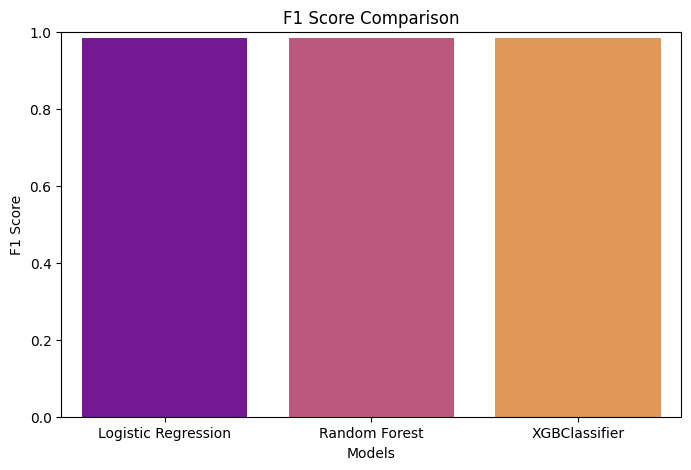

In [183]:
plt.figure(figsize=(8,5))
sns.barplot(x="model_name", y="f1", data=results_df, hue = "model_name", palette="plasma")
plt.title("F1 Score Comparison")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()

## Streamlit

In [ ]:
! streamlit run app.py